# 数据处理+特征工程
train_x.shape = (1381, 1246)
test_x.shape  = (150, 1246)

In [1]:
# -*- coding: UTF-8 -*-
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

In [2]:
train = pd.read_csv('jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('jinnan_round1_testA_20181227.csv', encoding = 'gb18030')

In [3]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
29,B1,21,0.716332,53.796562,float64
23,A23,3,0.214900,99.641834,float64
21,A21,12,0.214900,89.828080,float64
30,B2,3,0.143266,98.424069,float64


In [4]:
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
25,A25,7,0.666667,42.000000,float64
27,A27,11,0.666667,47.333333,float64
20,A20,52,0.666667,20.000000,object
29,B1,13,0.666667,56.000000,float64


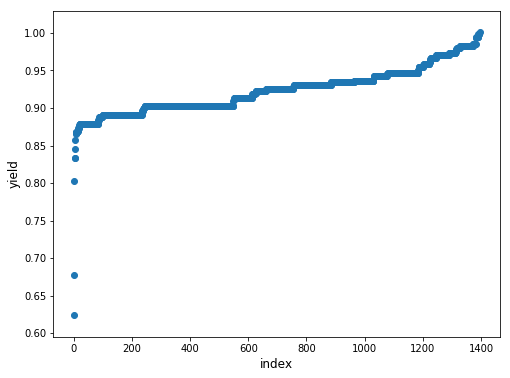

In [5]:
target_col = "收率"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

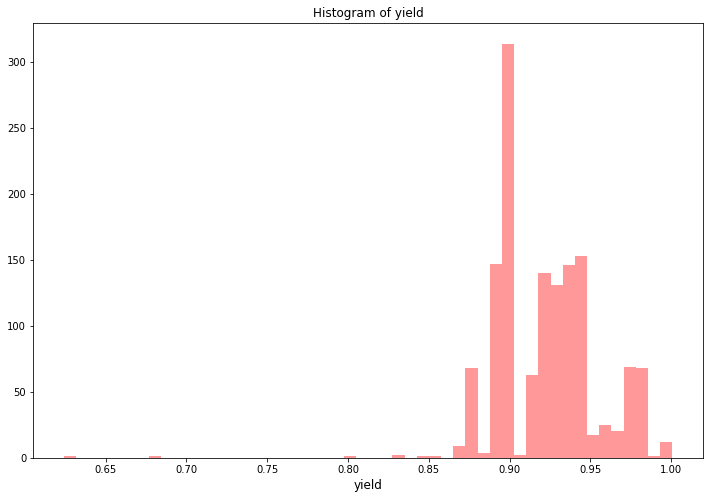

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col].values, bins=50, kde=False, color="red")
train_y = pd.DataFrame(train[target_col].values)
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()
train_y = train[target_col]

In [7]:
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [8]:
# 删除某一类别占比超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col,rate)
# 暂时不删除，后面构造特征需要
good_cols.append('A1')
good_cols.append('A3')
good_cols.append('A4')

A1 0.9863896848137536
A2 0.9699140401146131
A3 0.9570200573065902
A4 0.9570200573065902
B2 0.9842406876790831


In [9]:
# 删除异常值
train = train[train['收率']>0.87]
        
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

In [10]:
# 合并数据集
target = train['收率']
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [11]:
# def timeTranSecond(t):
#     try:
#         t,m,s=t.split(":")
#     except:
#         if t=='1900/1/9 7:00':
#             return 7*3600/3600
#         elif t=='1900/1/1 2:30':
#             return (2*3600+30*60)/3600
#         elif t==-1:
#             return -1
#         else:
#             return 0
    
#     try:
#         tm = (int(t)*3600+int(m)*60+int(s))/3600
#     except:
#         return (30*60)/3600
    
#     return tm
# for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
#     try:
#         data[f] = data[f].apply(timeTranSecond)
#     except:
#         print(f,'应该在前面被删除了！')

# def getDuration(se):
#     try:
#         sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
#     except:
#         if se == -1:
#             return -1 
        
#     try:
#         if int(sh)>int(eh):
#             tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
#         else:
#             tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
#     except:
#         if se=='19:-20:05':
#             return 1
#         elif se=='15:00-1600':
#             return 1
    
#     return tm
# for f in ['A20','A28','B4','B9','B10','B11']:
#     data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)
#将时间信息转化为小时
import re
def t2s(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7
        elif t=='1900/1/1 2:30':
            return -1
        else:
            return -1
    
    try:
        tm = int(t)*3600+int(m)*60+int(s)

    except:
        return -1
    
    return tm/3600
for f in ['A5','A9','A11','A14','A16','A24','A26','B5','B7']:
    data[f] = data[f].apply(t2s)

def getStartTime(se):

    try:
        sh,sm,eh,em=re.split("[:,-]",se)
    except:
        if se=='14::30-15:30':
            return 14.5
        elif se=='13；00-14:00':
            return 13
        elif se=='21:00-22；00':
            return 21
        elif se=='22"00-0:00':
            return 22
        elif se=='2:00-3;00':
            return 2
        elif se=='1:30-3;00':
            return 1.5
        elif se=='15:00-1600':
            return 15
        elif se=='19:-20:05':
            return 19
        else:
            return -1
        
    try:
        timestart = int(sh)+int(sm)/60
    except:
        return -1
    
    return int(timestart)

data['st6'] = data.apply(lambda df: getStartTime(df['A20']), axis=1)
data['st9'] = data.apply(lambda df: getStartTime(df['A28']), axis=1)
data['st10'] = data.apply(lambda df: getStartTime(df['B4']), axis=1)
data['st13'] = data.apply(lambda df: getStartTime(df['B9']), axis=1)
data['st14'] = data.apply(lambda df: getStartTime(df['B10']), axis=1)
data['st15'] = data.apply(lambda df: getStartTime(df['B11']), axis=1)

# def getNum(se):
#     try:
#         example,num=re.split("[-]",se)
#     except:
#         return None    
#     return int(num)
# data['Id'] = data.apply(lambda df: getNum(df['Id']), axis=1)


def getDuration(se):
    timelasting = 0
    try:
        sh,sm,eh,em=re.split("[:,-]",se)
    except:
        if se=='14::30-15:30':
            return 1
        elif se=='13；00-14:00':
            return 1
        elif se=='21:00-22；00':
            return 1
        elif se=='22"00-0:00':
            return 2
        elif se=='2:00-3;00':
            return 1
        elif se=='1:30-3;00':
            return 1.5
        elif se=='15:00-1600':
            return 1
        elif se=='19:-20:05':
            return 1
        else:
            return -1

        
    try:
        if(int(eh)>int(sh)):
            timelasting = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
        elif(int(eh)<int(sh)):
            timelasting = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
    except:
        return -1
    return int(timelasting)

for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data[f].apply(getDuration)

In [12]:
data['样本id'] = data['样本id'].apply(lambda x: int(x.split('_')[1]))

categorical_columns = [f for f in data.columns if f not in ['样本id']]
numerical_columns = [f for f in data.columns if f not in categorical_columns]

In [13]:
# 有风的冬老哥，在群里无意爆出来的特征，让我提升了三个个点，当然也可以顺此继续扩展
data['b14/a1_a3_a4_a19_b1_b12'] = data['B14']/(data['A1']+data['A3']+data['A4']+data['A19']+data['B1']+data['B12'])

numerical_columns.append('b14/a1_a3_a4_a19_b1_b12')

# del data['A1']
# del data['A3']
# del data['A4']
# categorical_columns.remove('A1')
# categorical_columns.remove('A3')
# categorical_columns.remove('A4')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 43 columns):
样本id                       1531 non-null int64
A5                         1531 non-null float64
A6                         1531 non-null float64
A7                         1531 non-null object
A8                         1531 non-null float64
A9                         1531 non-null float64
A10                        1531 non-null int64
A11                        1531 non-null float64
A12                        1531 non-null float64
A14                        1531 non-null float64
A15                        1531 non-null float64
A16                        1531 non-null float64
A17                        1531 non-null float64
A19                        1531 non-null int64
A20                        1531 non-null int64
A21                        1531 non-null float64
A22                        1531 non-null float64
A24                        1531 non-null float64
A25                 

In [15]:
#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]
train

,样本id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A21,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14,A1,A3,A4,st6,st9,st10,st13,st14,st15,b14/a1_a3_a4_a19_b1_b12
0,1528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.140105
1,1698,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,0,1,1,1,1,1,1,0.128000
2,639,1,1,0,0,1,2,1,1,1,1,1,1,1,0,0,0,1,2,1,1,1,1,0,1,1,2,0,0,0,1,1,0,0,0,0,1,1,1,2,2,2,0.128000
3,483,2,0,0,0,2,0,2,0,2,0,2,0,1,0,0,1,2,3,2,2,1,2,0,2,0,3,0,0,0,0,0,0,0,0,0,2,2,2,3,3,0,0.148423
4,617,3,1,0,0,3,1,3,1,3,1,3,1,1,1,0,0,3,1,3,1,1,1,0,3,1,4,0,0,0,1,1,1,0,0,0,3,3,3,4,4,3,0.134400
5,373,4,2,1,1,4,0,4,1,4,1,4,2,0,0,0,0,4,3,4,3,0,3,1,4,0,5,0,0,0,0,0,1,0,0,0,4,4,4,5,5,0,0.167732
6,577,5,1,0,0,5,1,5,1,5,1,5,1,1,1,0,0,5,1,5,1,1,1,0,5,1,6,0,0,0,1,1,0,0,0,0,5,5,5,3,6,4,0.128000
7,212,6,1,0,0,6,1,6,0,6,0,6,3,1,1,0,0,4,4,6,1,1,1,0,6,1,7,0,0,0,1,1,0,0,0,0,4,2,2,6,7,5,0.128000
8,521,7,3,0,0,7,0,7,2,7,2,7,1,0,0,0,0,6,3,7,2,1,4,0,7,0,8,0,0,0,0,0,1,0,0,0,6,6,6,1,8,0,0.147627
9,1026,8,3,0,0,8,0,8,0,8,0,8,1,1,0,0,0,7,3,8,2,1,5,0,8,2,9,1,0,0,0,0,0,0,0,0,7,7,7,1,8,0,0.148976


In [16]:
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_columns = []
for f1 in categorical_columns:
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if cate_rate < 0.90:
        for f2 in li:
            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
            mean_columns.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            train[col_name] = train['B14'].map(order_label)
            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
            if miss_rate > 0:
                train = train.drop([col_name], axis=1)
                mean_columns.remove(col_name)
            else:
                test[col_name] = test['B14'].map(order_label)
                
train.drop(li+['target'], axis=1, inplace=True)
train_x = train
test_x = test
print(train.shape)
print(test.shape)

(1381, 148)
(150, 148)


In [17]:

# train_x = train[mean_columns+numerical_columns].values
# test_x = test[mean_columns+numerical_columns].values
# # one hot
# enc = OneHotEncoder()
# for f in categorical_columns:
#     enc.fit(data[f].values.reshape(-1, 1))
#     train_x = sparse.hstack((train_x, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
#     test_x = sparse.hstack((test_x, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
# print(train_x.shape)
# print(test_x.shape)
# print(train_x.shape)
# print(test_x.shape)
# train_x = pd.DataFrame(train_x.todense())
# test_x = pd.DataFrame(test_x.todense())
# print(type(train_x))
# print(type(test_x))
# xxx = pd.concat([train_x,train_y],axis = 1)
# print(xxx.shape)
# print(type(xxx))

In [18]:
# train_y = (target[:,0])
train_y = target.values

# SVM

In [19]:
# from sklearn import preprocessing
# from sklearn import linear_model, svm, gaussian_process
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# import numpy as np
# x = train_x
# y = train_y

# x_scaled = preprocessing.StandardScaler().fit_transform(x)
# y_scaled = preprocessing.StandardScaler().fit_transform(y)
# X_train,X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)


In [20]:
# clfs = {
#         'svm':svm.SVR(), 
#         'RandomForestRegressor':RandomForestRegressor(n_estimators=400),
#         'BayesianRidge':linear_model.BayesianRidge()
#        }
# for clf in clfs:
#     try:
#         clfs[clf].fit(X_train, y_train)
#         y_pred = clfs[clf].predict(X_test)
#         print(clf + " cost:" + str((y-y_pred)**2)/(2*len(y)))
#     except Exception as e:
#         print(clf + " Error:")
#         print(str(e))
        

# XGBoost(未完成)

In [21]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))/(2*len(y))

In [22]:
# X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=7)
# # fit model on all training data
# model = XGBClassifier()
# model.fit(X_train, y_train)
# plot_importance(model)
# pyplot.show()
# # make predictions for test data and evaluate
# y_pred = model.predict(X_test)


In [23]:
# print(y_test.shape)
# print(y_pred.shape)
# accuracy = ((y_test-y_pred)**2).mean()/2
# print("Accuracy = {}".format(accuracy))

In [24]:
# thresholds = sorted(model.feature_importances_)
# print(thresholds)
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(model, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(X_train)
#     # train model
#     selection_model = XGBClassifier()
#     selection_model.fit(select_X_train, y_train)
#     # eval model
#     select_X_test = selection.transform(X_test)
#     y_pred = selection_model.predict(select_X_test)
#     accuracy = ((y_test-y_pred)**2).mean()/2
#     print("Accuracy = {}".format(accuracy))

In [25]:
# X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=7)
# lgb_train = lgb.Dataset(X_train, Y_train)
# lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)

In [26]:
# params = {
#     'num_leaves': 5,
#     'metric': ('l1', 'l2'),
#     'verbose': 0
# }

# evals_result = {}  # to record eval results for plotting

# print('Starting training...')
# # train
# gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=100,
#                 valid_sets=[lgb_train, lgb_test],
#                 feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
#                 categorical_feature=[21],
#                 evals_result=evals_result,
#                 verbose_eval=10)

# print('Plotting metrics recorded during training...')
# ax = lgb.plot_metric(evals_result, metric='l1')
# plt.show()

# print('Plotting feature importances...')
# ax = lgb.plot_importance(gbm, max_num_features=10)
# plt.show()


In [27]:
def get_lgb_stack_data(params,rounds,train,col,label,test):
    ID = []
    train = train.reset_index(drop=True)
    kf = KFold(n_splits=5,shuffle=False)
    i=0
    R2_Score = []
    RMSE = []
    evals_result0 = {}  # to record eval results for plotting
    for train_index, test_index in kf.split(train_x,pd.DataFrame(train_y)):
        print("Training "+str(i+1)+' Fold')
        X_train, X_test = train_x.iloc[train_index],train_x.iloc[test_index]
        y_train, y_test = train_y[train_index],train_y[test_index]
        train_lgb=lgb.Dataset(X_train[col],y_train)
        model = lgb.train(params,
                          train_lgb,
                          num_boost_round=rounds)
        pred = model.predict(X_test[col])
        X_test['label'] = list(y_test)
        X_test['predicted'] = pred
        r2 = score(y_test,pred)
        print('R2 Scored of Fold '+str(i+1)+' is '+str(r2))
        
  
        if i==0:
            Final = X_test
        else:
            Final = Final.append(X_test,ignore_index=True)
        i+=1
    lgb_train_ = lgb.Dataset(train[col],label)
    print('Start Training')
    model_ = lgb.train(params,
                       lgb_train_,
                       num_boost_round=rounds,
                       evals_result=evals_result0)

    
#     print('Plotting metrics recorded during training...')
#     ax = lgb.plot_metric(evals_result0, metric='l1')
#     plt.show()

    print('Plotting feature importances...')
    ax = lgb.plot_importance(model_, max_num_features=20)
    plt.show()
    
    Final_pred = model_.predict(test[col])

    print('Calculating In-Bag R2 Score')
    print(score(train_y, model.predict(train[col])))

    return Final,Final_pred 
def score(predictions, targets):
    return ((predictions - targets) ** 2).mean()/2


Training 1 Fold
R2 Scored of Fold 1 is 7.534695491283886e-05
Training 2 Fold
R2 Scored of Fold 2 is 8.639991148551675e-05
Training 3 Fold
R2 Scored of Fold 3 is 7.602405798864065e-05
Training 4 Fold
R2 Scored of Fold 4 is 6.60548503055859e-05
Training 5 Fold
R2 Scored of Fold 5 is 8.739553614194854e-05
Start Training
Plotting feature importances...


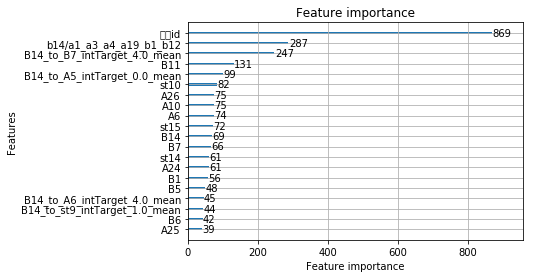

Calculating In-Bag R2 Score
6.800589981346958e-05


In [28]:
params = {
            'objective': 'regression',
            'metric': ('l1', 'l2'),
            'boosting': 'gbdt',
            'learning_rate': 0.01 , #small learn rate, large number of iterations
            'verbose': 0,
            'num_iterations': 500,
            'bagging_fraction': 0.95,
            'bagging_freq': 1,
            'bagging_seed': 42,
            'feature_fraction': 0.95,
            'feature_fraction_seed': 42,
            'max_bin': 100,
            'max_depth': 3,
            'num_rounds': 800
        }
col = list(test.columns)
lgb_train, lgb_test = get_lgb_stack_data(params,800,pd.DataFrame(train_x),col,pd.DataFrame(train_y),pd.DataFrame(test_x))

In [30]:
prediction = pd.DataFrame(lgb_test, columns=['SalePrice'])
test = pd.read_csv('test.csv',encoding="ISO-8859-1")
result = pd.concat([test['Id'], prediction], axis=1)
result.to_csv('./Predictions0116(3)_lgb_lr0.01score6.8.csv', index=False)